In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression

import support_functions as sf
from mpl_toolkits.mplot3d import Axes3D
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from tqdm.notebook import tqdm
import copy

from aix360.metrics.local_metrics import faithfulness_metric
from aix360.metrics.local_metrics import monotonicity_metric

# sharp plots with higher resolution
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

from matplotlib import rc


In [2]:
path_figures = '/Users/svennomm/Library/CloudStorage/GoogleDrive-sven.nomm@gmail.com/My Drive/Articles/ICMLA_2024_Miami_xai/figures/'

In [3]:
def gaussian_generator(center, eig_val, eig_vec, size):
    sigma = np.matmul(np.matmul(eig_vec, eig_val), np.transpose(eig_vec))
    data_set = np.random.multivariate_normal(center, sigma, size)

    return data_set

In [4]:
n_1 = 1000  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

data_set = gaussian_generator(mu_1,w_1, v_1, n_1)


rotation_angle = np.pi / 2
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

coord_data = np.transpose(data_set[:, 0:2])
data_set[:, 0:2] = np.transpose(np.matmul(rotation_matrix, coord_data))


In [5]:
# I will use 0 and 1 as class ID
# Linearly separated hard margin
data_set_0 = data_set[data_set[:, -1] <= 0]
data_set_0[:, 1] =  data_set_0[:, 1] - 0.2
data_set_1 = data_set[data_set[:, -1] > 0]
labels_0 = np.zeros((len(data_set_0), 1))
labels_1 = np.ones((len(data_set_1), 1))
data_set_0 = np.concatenate((data_set_0, labels_0), axis=1)
data_set_1 = np.concatenate((data_set_1, labels_1), axis=1)
data_set_lin_sep_hm = np.concatenate((data_set_0, data_set_1), axis=0)
np.random.shuffle(data_set_lin_sep_hm)

In [6]:
# Linearly separated soft margin
data_set_0 = data_set[data_set[:, -1] <= 0]
data_set_0[:, 1] =  data_set_0[:, 1] + 0.2
data_set_1 = data_set[data_set[:, -1] > 0] 
labels_0 = np.zeros((len(data_set_0), 1))
labels_1 = np.ones((len(data_set_1), 1))
data_set_0 = np.concatenate((data_set_0, labels_0), axis=1)
data_set_1 = np.concatenate((data_set_1, labels_1), axis=1)
data_set_lin_sep_sm = np.concatenate((data_set_0, data_set_1), axis=0)
np.random.shuffle(data_set_lin_sep_sm)

In [7]:
# nonlinear decision boundary
theta = np.linspace(-3, 3, 60, endpoint=False)

hyper_surface = np.sin(theta * 6) / 3
support_surface_1 = hyper_surface - 0.5
support_surface_2 = hyper_surface + 0.5

hyper_surface_z = np.zeros(hyper_surface.shape)

In [8]:
# hard margine case
data_set_0 = data_set[data_set[:, -1] <= np.sin(data_set[:, 0] * 6) / 2 ]
data_set_0[:, 1] =  data_set_0[:, 1] - 0.2
data_set_1 = data_set[data_set[:, -1] > np.sin(data_set[:, 0] * 6) / 2 ]
labels_0 = np.zeros((len(data_set_0), 1))
labels_1 = np.ones((len(data_set_1), 1))
data_set_0 = np.concatenate((data_set_0, labels_0), axis=1)
data_set_1 = np.concatenate((data_set_1, labels_1), axis=1)
data_set_nonlin_sep_hm = np.concatenate((data_set_0, data_set_1), axis=0)
np.random.shuffle(data_set_nonlin_sep_hm)

In [9]:
data_set_0 = data_set[data_set[:, -1] <= np.sin(data_set[:, 0] * 6) / 2 ]
data_set_0[:, 1] =  data_set_0[:, 1] + 0.2
data_set_1 = data_set[data_set[:, -1] > np.sin(data_set[:, 0] * 6) / 2 ]
labels_0 = np.zeros((len(data_set_0), 1))
labels_1 = np.ones((len(data_set_1), 1))
data_set_0 = np.concatenate((data_set_0, labels_0), axis=1)
data_set_1 = np.concatenate((data_set_1, labels_1), axis=1)
data_set_nonlin_sep_sm = np.concatenate((data_set_0, data_set_1), axis=0)
np.random.shuffle(data_set_nonlin_sep_sm)

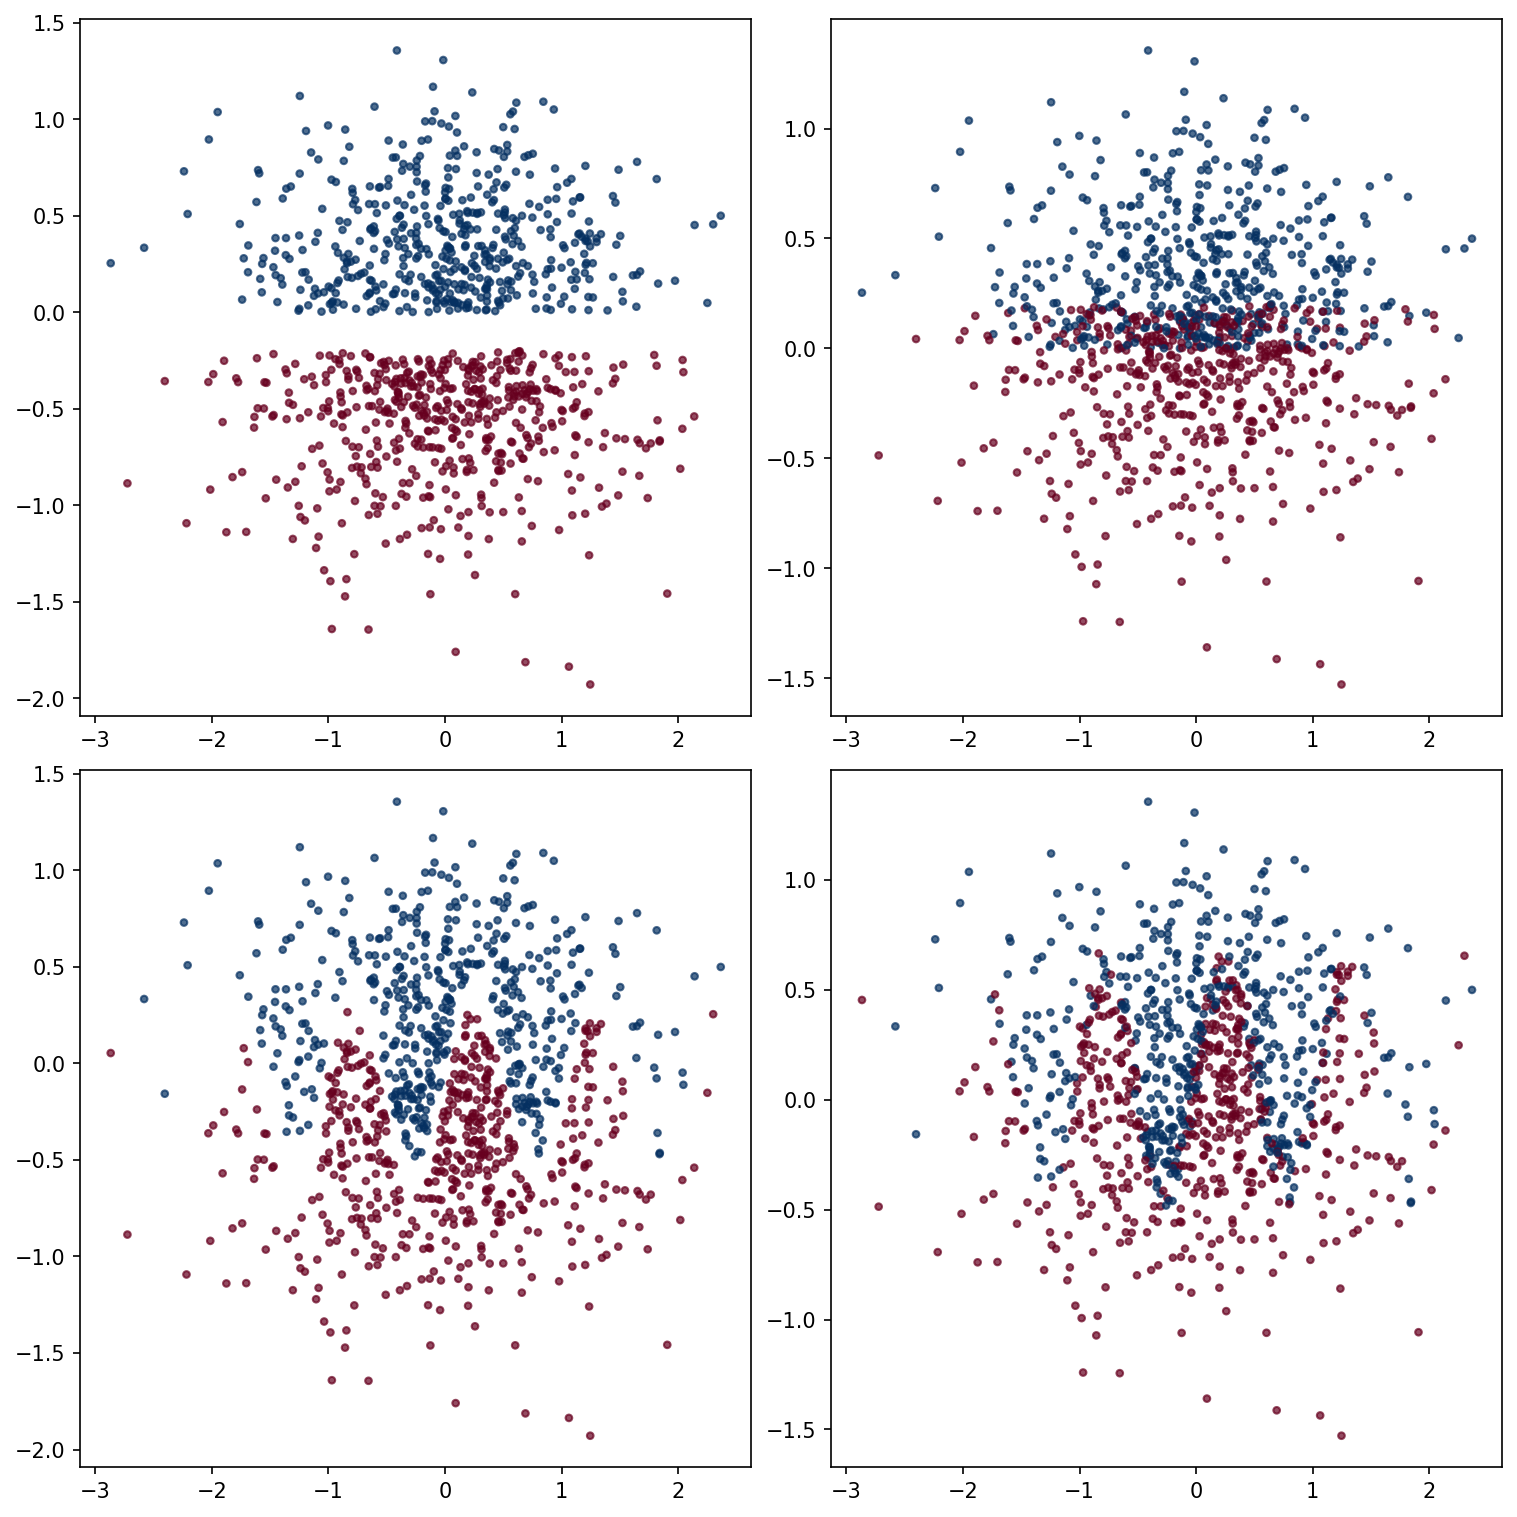

In [10]:
# plot the data sets
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['ps.useafm'] = True
#rc('font',**{'family':'sans-serif','sans-serif':['FreeSans']})  # causes error messages
plt.rcParams['pdf.fonttype'] = 42
fig_1, ((ax_11, ax_12), (ax_21, ax_22)) = plt.subplots(2,2, layout='constrained')

plt.subplot(221)
#plt.title('Linear decision boundary hard margin')
ax_11.scatter(data_set_lin_sep_hm[:, 0], data_set_lin_sep_hm[:, 1], c= data_set_lin_sep_hm[:, 2], cmap='RdBu', s=10, alpha=0.7)
#ax_11.set_aspect('equal')
#ax_11.get_figure().savefig(path_figures + 'data_set_lin_sep_hm.pdf', dpi=300)


plt.subplot(222)
#plt.title('Linear decision boundary soft margin')
ax_12.scatter(data_set_lin_sep_sm[:, 0], data_set_lin_sep_sm[:, 1], c= data_set_lin_sep_sm[:, 2], cmap='RdBu', s=10, alpha=0.7)
#ax_12.set_aspect('equal')

plt.subplot(223)
#plt.title('Non-linear decision boundary hard margin')
ax_21.scatter(data_set_nonlin_sep_hm[:, 0], data_set_nonlin_sep_hm[:, 1], c= data_set_nonlin_sep_hm[:, 2], cmap='RdBu', s=10, alpha=0.7)
#ax_21.set_aspect('equal')

plt.subplot(224)
#plt.title('Non-linear decision boundary soft margin')
ax_22.scatter(data_set_nonlin_sep_sm[:, 0], data_set_nonlin_sep_sm[:, 1], c= data_set_nonlin_sep_sm[:, 2], cmap='RdBu', s=10, alpha=0.7)
#ax_22.set_aspect('equal')
plt.savefig(path_figures + 'data_sets.pdf', dpi=300)


plt.show()


In [11]:
def get_coefficients(index, X_test, classifier, lime_explainer):
    exps_instance = lime_explainer.explain_instance(X_test[index], classifier.predict_proba, num_features=2, top_labels=2)
    predicted_class = classifier.predict(X_test[index].reshape(1, -1))[0]
    #print("Predicted class: ", predicted_class)
    local_exps = exps_instance.local_exp[predicted_class]
    #print("Local explanations: ", local_exps)
    coefs = np.zeros(X_test.shape[1])
    for v in local_exps:
        coefs[v[0]] = v[1]
    return local_exps, exps_instance, coefs

In [12]:
from sklearn.neighbors import NearestNeighbors
def classify_explain_evaluate(X_train, X_test, y_train, y_test, flat_grid, grid_elements, classifier, explainer, data_name,
                              print_metrics):
    classifier.fit(X_train, y_train)
    y_hat = classifier.predict(X_test)
    classifier_name = type(classifier)
    print(classifier_name)
    if print_metrics:
        print(data_name, ' ', classifier_name, ' accuracy score: ', accuracy_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' precision score: ', precision_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' recall score: ', recall_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' f1 score: ', f1_score(y_test, y_hat))

    hat_grid = classifier.predict(flat_grid)
    db = sf.get_decision_boundary(grid_elements, hat_grid, flat_grid)
    
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(db)
    
    
    explainer_type_internal = type(explainer).__name__
    print('Using: ', explainer_type_internal)
    exp_grid_weights = []
    if explainer_type_internal == 'LimeTabularExplainer':
        print('lime')
        x = flat_grid[:, 0]
        n_grid = len(flat_grid)
        exp_grid_weights = np.zeros((n_grid, 2))
        faithfulness = np.zeros((n_grid, 1))
        monotonicity = np.zeros((n_grid, 1))
        
        faithfulness_m = np.zeros((n_grid, 1))
        monotonicity_m = np.zeros((n_grid, 1))
        
        faithfulness_db = np.zeros((n_grid, 1))
        monotonicity_db= np.zeros((n_grid, 1))

        for i in range(0, n_grid-1):
            #le, exp_svc_rot, coefs = get_coefficients(i, X_test, classifier, explainer)
            exp_svc_rot = explainer.explain_instance(data_row=flat_grid[i, :], predict_fn=classifier.predict_proba, num_features=2, top_labels=2)
            predicted_class = classifier.predict(flat_grid[i,:].reshape(1, -1))[0]
            local_exps = exp_svc_rot.local_exp[predicted_class]
            coefs = np.zeros(X_test.shape[1])
            for v in local_exps:
                coefs[v[0]] = v[1]
            
            
            base = np.zeros(flat_grid[i, :].shape[0])
            base_m = np.mean(X_train, axis=0)
            _, idx = neigh.kneighbors(flat_grid[i, :].reshape(1, -1))
            base_db = db[idx[0], :].reshape(2, -1)
            
            faithfulness[i, 0] = faithfulness_metric(classifier, flat_grid[i, :], coefs, base)
            monotonicity[i, 0] = monotonicity_metric(classifier, flat_grid[i, :], coefs, base)
            
            faithfulness_m[i, 0] = faithfulness_metric(classifier, flat_grid[i, :], coefs, base_m)
            monotonicity_m[i, 0] = monotonicity_metric(classifier, flat_grid[i, :], coefs, base_m)
            
            faithfulness_db[i, 0] = faithfulness_metric(classifier, flat_grid[i, :], coefs, base_db)
            monotonicity_db[i, 0] = monotonicity_metric(classifier, flat_grid[i, :], coefs, base_db)


            #a =exp_svc_rot.as_list()
            exp_grid_weights[i, 1] = exp_svc_rot.as_list()[0][1]
            exp_grid_weights[i, 0] = exp_svc_rot.as_list()[1][1]  # NB!  observe the chane of indexes due to the fact
            # that second feature comes first

    elif explainer_type_internal == 'str':
        print('shap')
        explainer_shap = shap.KernelExplainer(classifier.predict_proba, X_train)
        exp_grid_weights = explainer_shap.shap_values(flat_grid)

    return y_hat, hat_grid, exp_grid_weights, faithfulness, monotonicity, faithfulness_m, monotonicity_m, faithfulness_db, monotonicity_db, db

In [13]:
clf_svc = SVC(kernel='rbf', probability=True)
clf_tree = tree.DecisionTreeClassifier()
clf_KNN = KNeighborsClassifier()
clf_GNB = GaussianNB()
clf_LR = LogisticRegression()

In [14]:
X = data_set_lin_sep_hm[:, 0:2].copy()
y = data_set_lin_sep_hm[:, 2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3, train_size=0.7)

n_test = len(X_test)
exp_weights = np.zeros((n_test, 2))
flat_grid, grid_elements  = sf.get_grid(data_set=X_test, step_size=0.1, idx_column=False)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=["feat1","feat2"],
                                                  class_names=["class1","class2"], mode='classification',
                                                discretize_continuous=False)

In [15]:
y_hat_l, hat_grid_l, exp_grid_weights_l, faithfulness, monotonicity, faithfulness_m, monotonicity_m, faithfulness_db, monotonicity_db, db = classify_explain_evaluate(X_train, X_test, y_train, y_test, flat_grid, grid_elements, clf_svc,  explainer_lime, data_name='original', print_metrics=False)

<class 'sklearn.svm._classes.SVC'>
Using:  LimeTabularExplainer
lime


/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/svennomm/miniconda3/envs/aix360/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: inv

In [25]:
faithfulness_grid = np.reshape(faithfulness, grid_elements[0].shape)
monotonicity_grid = np.reshape( monotonicity, grid_elements[0].shape)
faithfulness_m_grid = np.reshape(faithfulness_m, grid_elements[0].shape)
monotonicity_m_grid = np.reshape( monotonicity_m, grid_elements[0].shape)
faithfulness_db_grid = np.reshape(faithfulness_db, grid_elements[0].shape)
monotonicity_db_grid = np.reshape( monotonicity_db, grid_elements[0].shape)

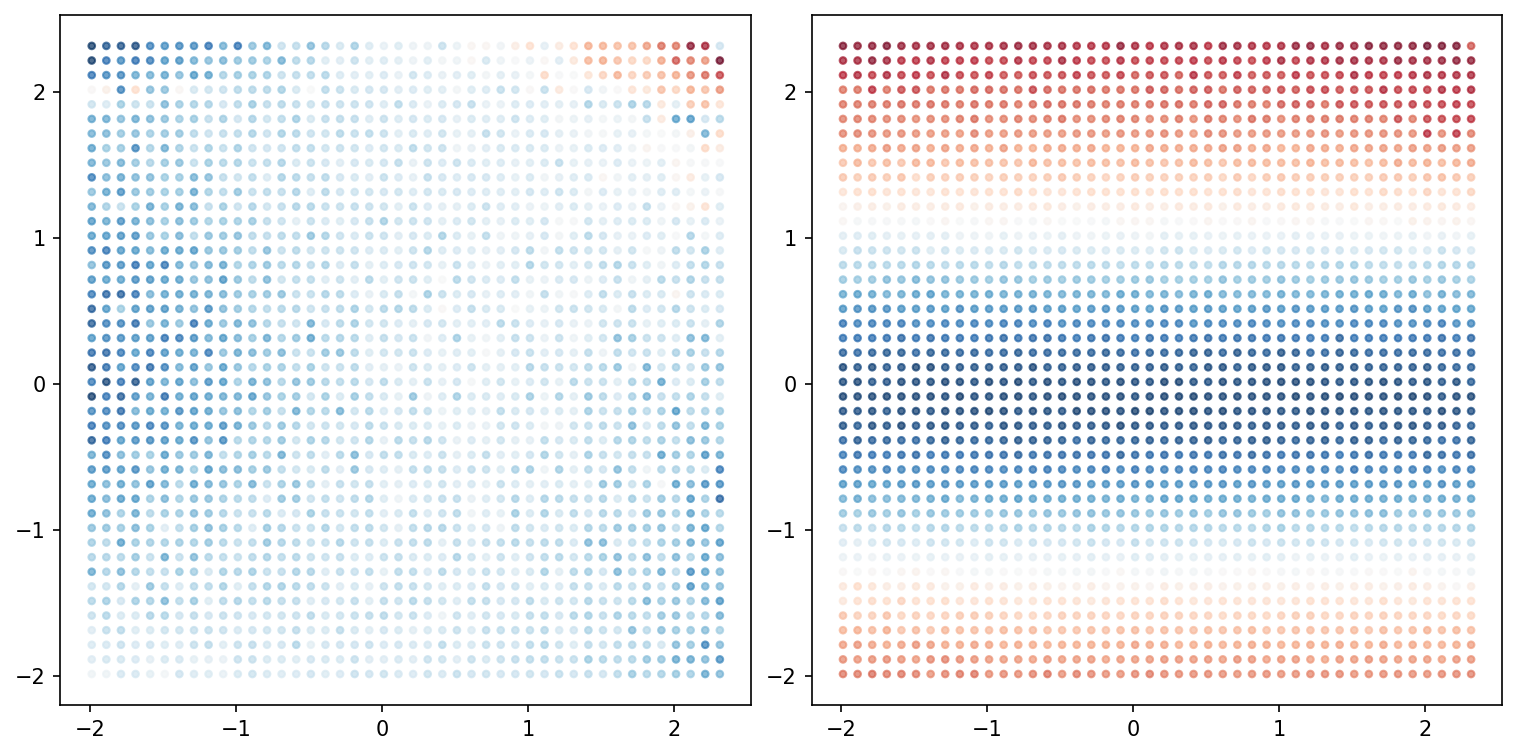

In [27]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['ps.useafm'] = True
#rc('font',**{'family':'sans-serif','sans-serif':['FreeSans']})  # causes error messages
plt.rcParams['pdf.fonttype'] = 42

fig_2, (ax_21, ax_22) = plt.subplots(1,2, layout='constrained')

plt.subplot(121)
#plt.title('lime voting for the first feature')
ax_21.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights_l[:, 0], cmap='RdBu', s=10, alpha=0.7)
#ax_21.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_21.set_aspect('equal')

plt.subplot(122)
#plt.title('lime voting for the second feature')
ax_22.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights_l[:, 1], cmap='RdBu', s=10, alpha=0.7)
#ax_22.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_22.set_aspect('equal')

plt.savefig(path_figures + "lime_voting_lin_svc_hm.pdf", bbox_inches='tight', dpi=300)
plt.show()




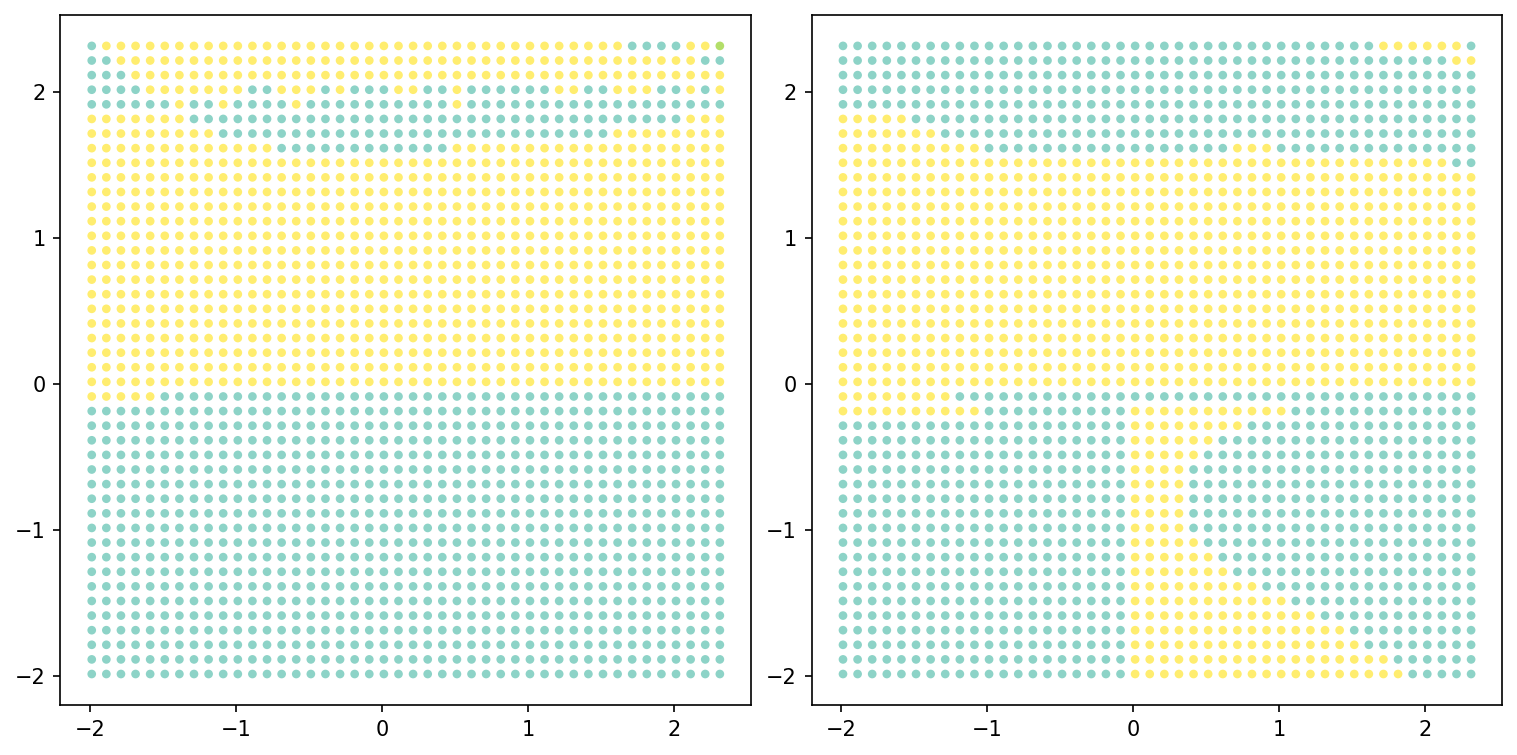

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['ps.useafm'] = True
#rc('font',**{'family':'sans-serif','sans-serif':['FreeSans']})  # causes error messages
plt.rcParams['pdf.fonttype'] = 42

fig_3, (ax_31, ax_32) = plt.subplots(1,2, layout='constrained')
plt.subplot(121)
values = faithfulness_grid.ravel()
#plt.title('lime faithfulness')
ax_31.scatter(flat_grid[:, 0], flat_grid[:, 1], c=values, cmap='Set3', s=10)
ax_31.set_aspect('equal')

plt.subplot(122)
values = monotonicity_grid.ravel()
#plt.title('lime monotonicity')
ax_32.scatter(flat_grid[:, 0], flat_grid[:, 1], c=values, cmap='Set3', s=10)
ax_32.set_aspect('equal')
plt.savefig(path_figures + "lin_svc_hm_lime_faith_and_monot.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# to do distances to decision boundary and local density overview correlations and stat stests